In [1]:
!git clone https://github.com/m-bashari-m/stock-forecast.git

Cloning into 'stock-forecast'...
remote: Enumerating objects: 32, done.
remote: Counting objects: 100% (32/32), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 32 (delta 7), reused 16 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (32/32), 98.04 KiB | 732.00 KiB/s, done.
Resolving deltas: 100% (7/7), done.


In [18]:
%cd stock-forecast

from utils.DataWindow import DataWindow

import os

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

[Errno 2] No such file or directory: 'stock-forecast'
/content/stock-forecast


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
DATA_DEST_PATH = '/content/drive/MyDrive/forecasting/'
DATA_VERSION = 'v1'

In [5]:
train_df = pd.read_csv(os.path.join(DATA_DEST_PATH, DATA_VERSION, 'train.csv'), index_col=0)
val_df = pd.read_csv(os.path.join(DATA_DEST_PATH, DATA_VERSION, 'val.csv'), index_col=0)
test_df = pd.read_csv(os.path.join(DATA_DEST_PATH, DATA_VERSION, 'test.csv'), index_col=0)

train_df.shape, val_df.shape, test_df.shape

((316334, 15), (90381, 15), (45192, 15))

#Single-Step Baseline Model

In [7]:
single_step_window = DataWindow(
    input_width=1,
    label_width=1,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    shift=1,
    label_columns=['close']
    )

wide_window = DataWindow(
    input_width=24,
    label_width=24,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    shift=1,
    label_columns=['close']
    )

In [10]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [12]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

baseline_last = Baseline(label_index=column_indices['close'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [15]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

2825/2825 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 1.2353e-06 - mean_absolute_error: 6.7936e-04


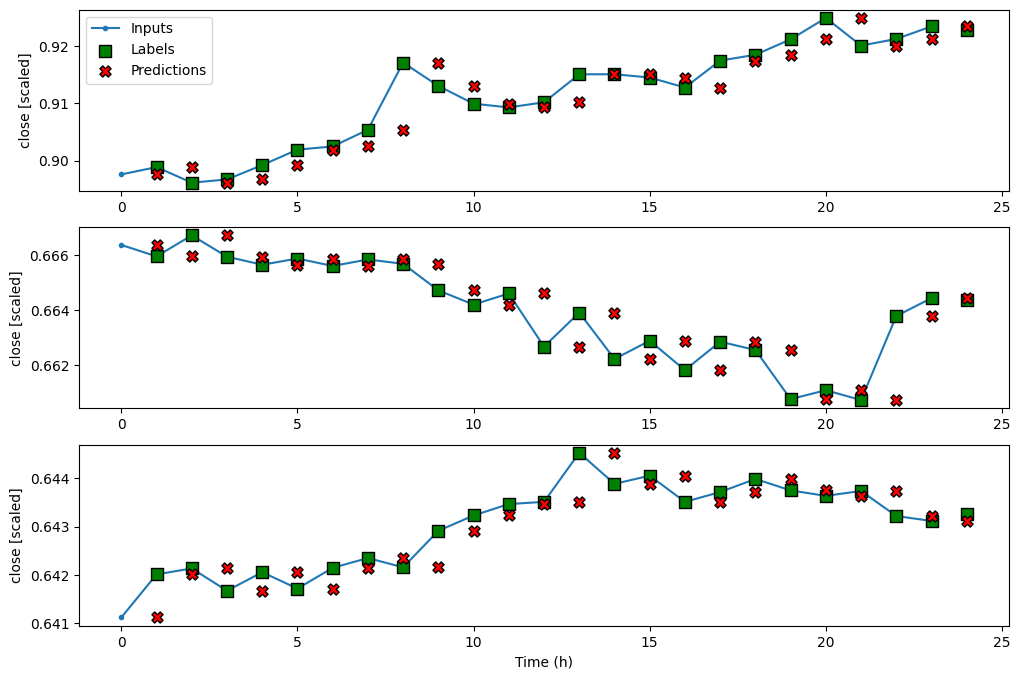

In [21]:
wide_window.plot(model=baseline_last, plot_col='close')

In [37]:
print(performance['Baseline - Last'][1])

0.0009788298048079014


#Multi-Step Baseline Model

In [38]:
multi_window = DataWindow(
    input_width=24,
    label_width=24,
    train_df=train_df,
    val_df=val_df,
    test_df=test_df,
    shift=24,
    label_columns=['close']
    )

In [39]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [40]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['close'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

2823/2823 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0595 - mean_absolute_error: 0.1105


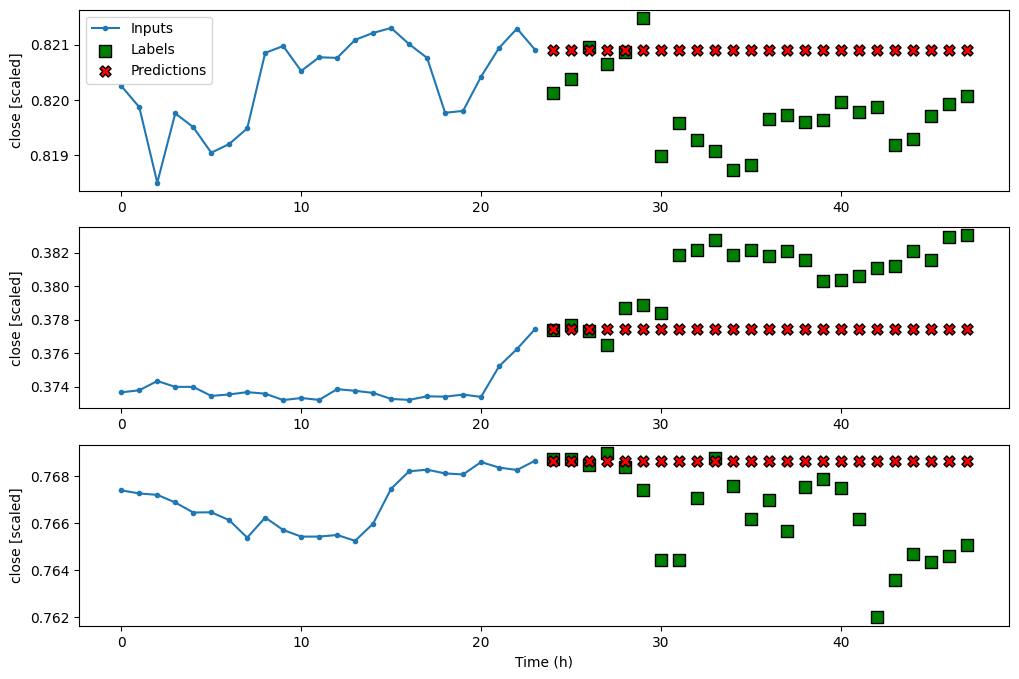

In [41]:
multi_window.plot(model=ms_baseline_last, plot_col='close')

In [42]:
print(ms_performance['Baseline - Last'][1])

0.21564272046089172


## Repeating Baseline Model

In [43]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [44]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['close'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

2823/2823 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0596 - mean_absolute_error: 0.1110


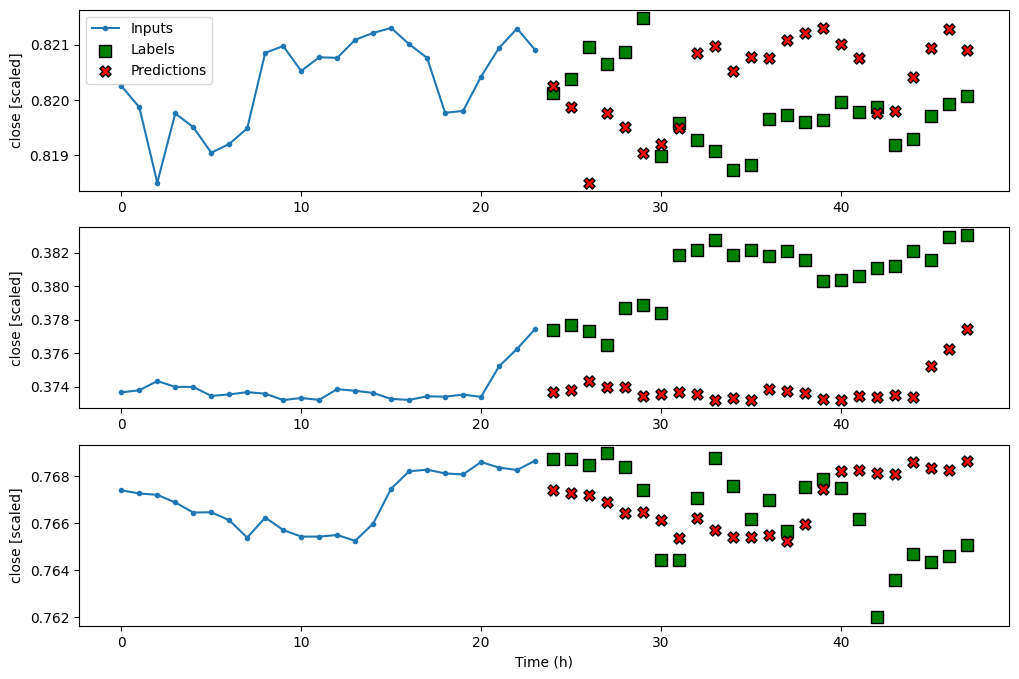

In [45]:
multi_window.plot(model=ms_baseline_repeat, plot_col='close')

In [47]:
print(ms_performance['Baseline - Repeat'][1])

0.21624983847141266
